In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded!")

✓ Libraries loaded!


In [3]:
df = pd.read_csv("../emails_data.csv")

print(f"Loaded {len(df)} emails")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 1296 emails
Columns: ['id', 'sender', 'subject', 'date', 'body_preview', 'snippet']


,id,sender,subject,date,body_preview,snippet
0,19aacf947138a527,Wingstop <wingstop@eclub.wingstop.com>,"Kickoff’s Here, California! Feast Mode: ON 🏈 🍗",2025-11-22 11:08:32-08:00,"\r\n\r\n\r\n\r\n \r\n\r\n[\r\n {\r\n ""@context"":""https://schema.org/"",\r\n ""@type"":""Organization...",Flavor Fit for Champions 🏆 💪 ✨ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏...
1,19aacec5e9c2493c,"""Habit Burger & Grill"" <habitburger@hello.habitburger.com>",Snag your free Chicken Club before it's gone! 🥪,2025-11-22 10:56:01-08:00,No lunch plans? We have an idea. Order Now \r\n( https://clicks.habitburger.com/f/a/FmK21tP6Dpp...,No lunch plans? We have an idea. ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌...
2,19aacc80ab246128,Russel C Paris Park Safety Posts <reply@rs.email.nextdoor.com>,I just had three helicopters circling my house.,2025-11-22 10:16:21-08:00,Nextdoor Russel C Paris Park Safety Posts\r\n\r\nI just had three helicopters circling my house....,They weren't there for more than about 10 minutes or so but one in particular was extremely low ...
3,19aacc632139b0a9,Your Russel C Paris Park neighbors <no-reply@is.email.nextdoor.com>,Top post: I have a room for rent in a three bedroom house. You would also...,2025-11-22 10:14:20-08:00,You would also have the front bathroom. You can park on the straight in front of the house. You ...,You would also have the front bathroom. You can park on the straight in front of the house. You ...
4,19aacad1f9fd0f12,Siddharth Sharma via LinkedIn <invitations@linkedin.com>,"Nathan, start a conversation with your new connection, Siddharth",2025-11-22 09:46:52-08:00,----------------------------------------\r\n\r\nThis email was intended for Nathan Nguyen (Data ...,"See Siddharth's connections, experience, and more ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ..."


In [4]:
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"Unique Senders: {df.get('sender').nunique()}")

Shape: (1296, 6)

Data Types:
id              object
sender          object
subject         object
date            object
body_preview    object
snippet         object
dtype: object

Missing values:
id               0
sender           0
subject          0
date             0
body_preview     0
snippet         31
dtype: int64
Unique Senders: 309


### Convert Data Types

In [16]:

print("Converting dates to Pacific Time...")

# Convert to UTC first, then to Pacific Time
df['datetime'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_convert('America/Los_Angeles')

# Extract time features in Pacific Time
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['date_only'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['day_of_month'] = df['datetime'].dt.day
df['is_weekend'] = df['datetime'].dt.weekday >= 5

# Time of day categories
df['time_of_day'] = pd.cut(
    df['hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night (12am-6am)', 'Morning (6am-12pm)', 
            'Afternoon (12pm-6pm)', 'Evening (6pm-12am)'],
    include_lowest=True
)

print(f"✓ Conversion complete!")
print(f"  Timezone: {df['datetime'].dt.tz}")
print(f"  Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"  Failed conversions: {df['datetime'].isna().sum()}")

print("\n📊 Sample data:")
print(df[['date', 'datetime', 'hour', 'day_of_week', 'time_of_day']].head(3))

print("\n✓ All times now in Pacific Time!")

Converting dates to Pacific Time...
✓ Conversion complete!
  Timezone: America/Los_Angeles
  Date range: 2025-10-21 17:35:29-07:00 to 2025-11-22 11:08:32-08:00
  Failed conversions: 0

📊 Sample data:
                        date                  datetime  hour day_of_week  \
0  2025-11-22 11:08:32-08:00 2025-11-22 11:08:32-08:00    11    Saturday   
1  2025-11-22 10:56:01-08:00 2025-11-22 10:56:01-08:00    10    Saturday   
2  2025-11-22 10:16:21-08:00 2025-11-22 10:16:21-08:00    10    Saturday   

          time_of_day  
0  Morning (6am-12pm)  
1  Morning (6am-12pm)  
2  Morning (6am-12pm)  

✓ All times now in Pacific Time!


# New DataFrame


In [23]:
df.head()

,id,sender,subject,date,body_preview,snippet,datetime,hour,day_of_week,date_only,month,year,day_of_month,is_weekend,time_of_day
0,19aacf947138a527,Wingstop <wingstop@eclub.wingstop.com>,"Kickoff’s Here, California! Feast Mode: ON 🏈 🍗",2025-11-22 11:08:32-08:00,"\r\n\r\n\r\n\r\n \r\n\r\n[\r\n {\r\n ""@context"":""https://schema.org/"",\r\n ""@type"":""Organization...",Flavor Fit for Champions 🏆 💪 ✨ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏...,2025-11-22 11:08:32-08:00,11,Saturday,2025-11-22,11,2025,22,True,Morning (6am-12pm)
1,19aacec5e9c2493c,"""Habit Burger & Grill"" <habitburger@hello.habitburger.com>",Snag your free Chicken Club before it's gone! 🥪,2025-11-22 10:56:01-08:00,No lunch plans? We have an idea. Order Now \r\n( https://clicks.habitburger.com/f/a/FmK21tP6Dpp...,No lunch plans? We have an idea. ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌...,2025-11-22 10:56:01-08:00,10,Saturday,2025-11-22,11,2025,22,True,Morning (6am-12pm)
2,19aacc80ab246128,Russel C Paris Park Safety Posts <reply@rs.email.nextdoor.com>,I just had three helicopters circling my house.,2025-11-22 10:16:21-08:00,Nextdoor Russel C Paris Park Safety Posts\r\n\r\nI just had three helicopters circling my house....,They weren't there for more than about 10 minutes or so but one in particular was extremely low ...,2025-11-22 10:16:21-08:00,10,Saturday,2025-11-22,11,2025,22,True,Morning (6am-12pm)
3,19aacc632139b0a9,Your Russel C Paris Park neighbors <no-reply@is.email.nextdoor.com>,Top post: I have a room for rent in a three bedroom house. You would also...,2025-11-22 10:14:20-08:00,You would also have the front bathroom. You can park on the straight in front of the house. You ...,You would also have the front bathroom. You can park on the straight in front of the house. You ...,2025-11-22 10:14:20-08:00,10,Saturday,2025-11-22,11,2025,22,True,Morning (6am-12pm)
4,19aacad1f9fd0f12,Siddharth Sharma via LinkedIn <invitations@linkedin.com>,"Nathan, start a conversation with your new connection, Siddharth",2025-11-22 09:46:52-08:00,----------------------------------------\r\n\r\nThis email was intended for Nathan Nguyen (Data ...,"See Siddharth's connections, experience, and more ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ...",2025-11-22 09:46:52-08:00,9,Saturday,2025-11-22,11,2025,22,True,Morning (6am-12pm)


### How many emails do I receive per day on average?

In [43]:
total_emails = len(df)
total_days = len(df.groupby('date_only'))
avg_emails = total_emails / total_days
print(f"Average emails per day this month: {avg_emails:.1f}")

Average emails per day this month: 39.3


### What is the busiest day of the week

In [44]:
days_of_week_df = df.groupby('day_of_week').count()
days_of_week_df = days_of_week_df.assign(Emails = days_of_week_df.get('id'))
days_of_week_df = days_of_week_df.get(['Emails']).sort_values(by = 'Emails', ascending = False)
days_of_week_df

,Emails
day_of_week,
Thursday,244
Wednesday,243
Tuesday,206
Friday,203
Monday,184
Saturday,118
Sunday,98


<Axes: xlabel='day_of_week'>

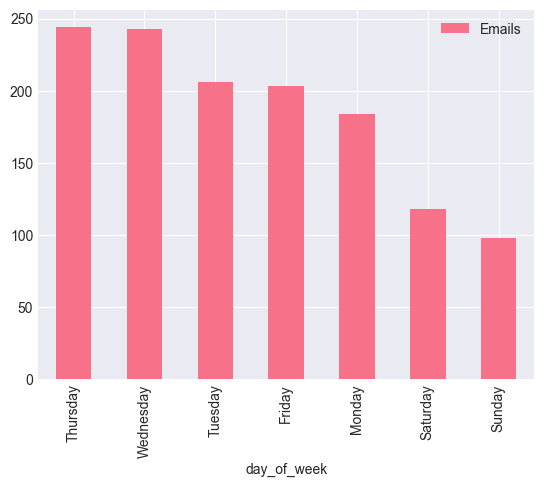

In [45]:
days_of_week_df.plot(kind = 'bar')

In [46]:
print(f"This month, {days_of_week_df.index[0]} is the busiest day of the week with {days_of_week_df.get('Emails').iloc[0]} emails received")

This month, Thursday is the busiest day of the week with 244 emails received


### What time of the day do I get the most emails?

In [52]:
peak_time_df = df.groupby('time_of_day').count()
peak_time_df = peak_time_df.assign(Emails = peak_time_df.get('id')).get(['Emails']).sort_values(by = 'Emails', ascending=False)
peak_time_df

/var/folders/95/q1g02_4s37qclyv89d1mkgzr0000gn/T/ipykernel_94159/2083476114.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  peak_time_df = df.groupby('time_of_day').count()


,Emails
time_of_day,
Morning (6am-12pm),602
Afternoon (12pm-6pm),350
Evening (6pm-12am),178
Night (12am-6am),166


<Axes: xlabel='time_of_day'>

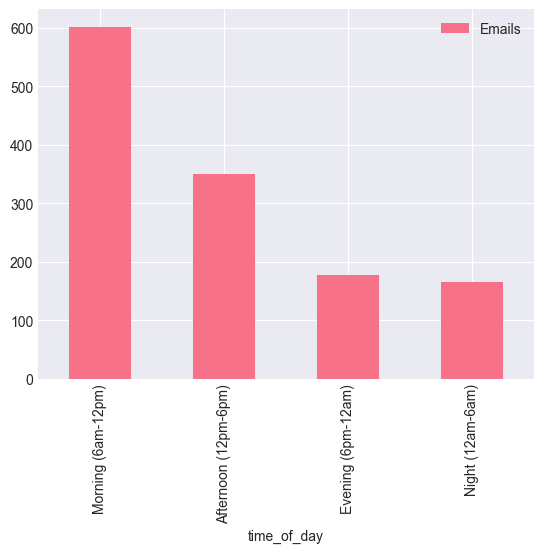

In [53]:
peak_time_df.plot(kind = 'bar')

In [54]:
peak_hour_df = df.groupby('hour').count()
peak_hour_df = peak_hour_df.assign(Emails = peak_hour_df.get('id')).get(['Emails']).sort_values(by = 'Emails', ascending=False)
peak_hour_df

,Emails
hour,
10,122
9,117
11,114
8,97
7,91
13,70
17,64
15,64
19,63


<Axes: xlabel='hour'>

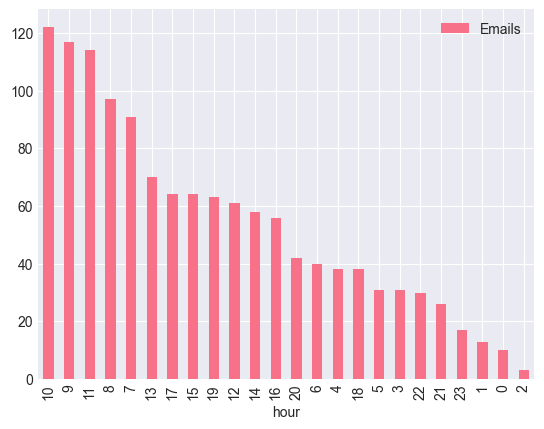

In [55]:
peak_hour_df.plot(kind = 'bar')

In [58]:
print(f"Peak time of day: {peak_time_df.index[0]}")
print(f"Peak hour of day: {peak_hour_df.index[0]}:00 (UTC)")

Peak time of day: Morning (6am-12pm)
Peak hour of day: 10:00 (UTC)


### Do I get more emails on the weekdays or weekends

In [77]:
weekday_df = df[df.get('is_weekend') == False]
weekday_count = weekday_df.shape[0]

weekend_df = df[df.get('is_weekend') == True]
weekend_count = weekend_df.shape[0]

print(f"# of Weekday Emails: {weekday_count}")
print(f"# of Weekend Emails: {weekend_count}")

# of Weekday Emails: 1080
# of Weekend Emails: 216
